# Identifying Clusters using Graph Convolutional Network (GCN) 

---------------------

## Problem Statement

The main goal of this project is to discover hidden structures and find natural groupings or clusters in a dataset that's structured like a network or graph. We aim to use the built-in patterns and the layout of connections in the graph to uncover hidden groups, patterns, or communities that we can't easily see just by looking at the data in ordinary ways. We're doing this without using any pre-existing labels or categories, relying entirely on the information that's already there in the structure of the graph itself.

---------------------

<img src="./img1.png" >

## Algorithm

## Graph Convolutional Network

How it works ?

Graph Convolutional Networks (GCNs) represent a powerful class of neural networks designed for learning on graphs. By extending the powerful capabilities of convolutional neural networks (CNNs) from grid-like data (such as images) to graph-structured data, GCNs have become pivotal in tasks involving non-Euclidean data. Here's a concise technical summary of how GCNs work:

Fundamental Concept
GCNs leverage the idea of convolution but adapt it to work on graph data. In traditional CNNs, convolutional filters slide across images (2D grids) to capture local patterns. For graphs, which are irregular and lack a global ordering of nodes, GCNs define convolution in terms of a node's neighborhood, allowing each node to learn from its immediate surroundings in the graph.

Key Components
Graph Structure: A graph G=(V,E) consists of nodes V and edges E, where nodes represent entities, and edges represent relationships between these entities. Graphs can be directed or undirected, weighted, or unweighted.

Feature Representation: Each node in the graph has an associated feature vector, which represents the attributes of the node. The collection of all node features can be represented as a feature matrix X.

Adjacency Matrix: The graph's structure is captured by the adjacency matrix A, where A-ij indicates the presence (and possibly the weight) of an edge from node i to node j.

------------------------------------------

#### 1. Importing the required packages

In [5]:
import numpy as np
import pandas as pd
import itertools
import random

import networkx as nx
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeFeatures
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim


random.seed(42)

In [6]:
nx.__version__

'2.8.8'

#### 2. Data (Payment.csv) import

In [7]:
data = pd.read_csv("Payments - Payments.csv")

In [8]:
data.head()

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456
3,1309,1011,120593
4,1309,1011,166396


#### 3. Exploratory Data Analysis (EDA)

In [9]:
data.describe()

,Sender,Receiver,Amount
count,130535.000000,130535.000000,1.305350e+05
mean,1309.358287,1182.851258,6.980968e+04
std,294.435026,169.809657,5.696676e+04
min,1001.000000,1001.000000,1.501000e+03
25%,1078.000000,1060.000000,2.411100e+04
50%,1214.000000,1112.000000,5.622000e+04
75%,1488.000000,1276.000000,1.079405e+05
max,2190.000000,1887.000000,2.124500e+06


In [10]:
print("------------------------------------------------------")
print("Total Unique Senders       : ",len(set(data['Sender'])))
print("Total Unique Receiver      : ",len(set(data['Receiver'])))
print("Total no of edges in Graph : ",data.shape[0])
print("Total no of nodes in Graph : ",len(np.unique(data[['Sender','Receiver']])))
print("------------------------------------------------------")

------------------------------------------------------
Total Unique Senders       :  703
Total Unique Receiver      :  371
Total no of edges in Graph :  130535
Total no of nodes in Graph :  799
------------------------------------------------------


In [11]:
data.shape

(130535, 3)

#### 4. Preprocessing

In [12]:
data.head(3)

,Sender,Receiver,Amount
0,1309,1011,123051
1,1309,1011,118406
2,1309,1011,112456


In [13]:
# Create an directed multi edge graph

G = nx.from_pandas_edgelist(data, 'Sender', 'Receiver', ['Amount'],create_using=nx.DiGraph())

print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))

Number of nodes: 799
Number of edges: 5358


##### 4.1 Unique Nodes and Node Mapping

In [14]:
unique_nodes = pd.concat([data['Sender'], data['Receiver']]).unique()
print("Count of Unique nodes : ",len(unique_nodes))

Count of Unique nodes :  799


In [15]:
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
node_mapping

{1309: 0,
 1259: 1,
 1568: 2,
 1147: 3,
 1393: 4,
 1039: 5,
 1210: 6,
 1042: 7,
 1045: 8,
 1256: 9,
 1668: 10,
 1163: 11,
 1007: 12,
 1034: 13,
 1832: 14,
 1099: 15,
 1488: 16,
 1801: 17,
 1076: 18,
 1944: 19,
 1659: 20,
 1205: 21,
 1220: 22,
 1837: 23,
 1222: 24,
 1017: 25,
 1023: 26,
 2085: 27,
 1503: 28,
 2088: 29,
 1350: 30,
 1327: 31,
 1276: 32,
 1666: 33,
 1056: 34,
 1748: 35,
 1658: 36,
 1228: 37,
 1074: 38,
 1138: 39,
 1089: 40,
 1002: 41,
 1623: 42,
 1264: 43,
 1875: 44,
 1004: 45,
 1595: 46,
 1090: 47,
 1051: 48,
 1101: 49,
 1079: 50,
 1104: 51,
 1839: 52,
 1747: 53,
 1135: 54,
 1656: 55,
 1500: 56,
 1148: 57,
 1136: 58,
 1172: 59,
 1132: 60,
 1809: 61,
 1774: 62,
 1037: 63,
 1930: 64,
 2184: 65,
 1243: 66,
 1293: 67,
 1990: 68,
 1690: 69,
 1449: 70,
 1310: 71,
 1679: 72,
 1159: 73,
 1335: 74,
 1862: 75,
 1049: 76,
 1105: 77,
 1766: 78,
 1541: 79,
 1961: 80,
 1575: 81,
 1189: 82,
 1723: 83,
 1962: 84,
 1084: 85,
 1480: 86,
 2146: 87,
 1405: 88,
 1016: 89,
 1729: 90,
 2166: 91

In [16]:
df = pd.DataFrame()

df['Sender'] = data['Sender'].map(node_mapping)
df['Receiver'] = data['Receiver'].map(node_mapping)
df

,Sender,Receiver
0,0,185
1,0,185
2,0,185
3,0,185
4,0,185
...,...,...
130530,93,152
130531,197,152
130532,197,152
130533,197,152


#### 5. Graph Convolutional Network

##### 5.1 Lets Create the Edge Index and edge attributes

In [17]:
# Create edge index and edge attributes (if necessary)
edge_index = torch.tensor([df['Sender'].values, df['Receiver'].values], dtype=torch.long)
edge_attr = torch.tensor(data['Amount'].values, dtype=torch.float).reshape(-1, 1)

C:\Users\HarshUdai\AppData\Local\Temp\ipykernel_23812\1839472916.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  edge_index = torch.tensor([df['Sender'].values, df['Receiver'].values], dtype=torch.long)


##### 5.2 Create one-hot endcoded features, since we dont have any features expilicitly

In [18]:
num_nodes = len(unique_nodes)

# Create one-hot encoded features
node_features_one_hot = torch.eye(num_nodes)

##### 5.3 Creating an instance of Data with pytorch geometrics

In [19]:
data_ = Data(x=node_features_one_hot, edge_index=edge_index, edge_attr=edge_attr)

In [20]:
data_

Data(x=[799, 799], edge_index=[2, 130535], edge_attr=[130535, 1])

----------------------------------

##### The Data object is particularly interesting. Printing it offers a good summary of the graph we're studying:

x=[799, 799] is the node feature matrix with shape (number of nodes, number of features). In our case, it means that we have 799 unique nodes , each node being associated to a 799-dim feature vector.

edge_index=[2, 130535] represents the graph connectivity (how the nodes are connected) with shape (2, number of directed edges).

edge_attr=[130535, 1] represents the weights associated with the edges.

--------------------------------

#### 6. GCN powered by Auto Encoder

<img src="./img4.png" />

#### Intution and idea from this IEEE research paper :

<a href="https://ieeexplore.ieee.org/document/9746161">Graph Convolutional Networks With Autoencoder-Based Compression And Multi-Layer Graph Learning</a>

-------------------------

#### GCN + Auto Encoder

Graph Convolutional Networks (GCNs) combined with autoencoders, specifically Graph Autoencoders (GAEs), form a powerful framework for unsupervised learning on graph-structured data. This approach leverages the strength of GCNs to capture graph topology and node feature information, alongside the autoencoder's capability to learn compressed, informative representations of data. Here's a concise technical summary:

Core Concepts

GCNs: Serve as the building block by applying convolutional operations on the graph to efficiently aggregate neighborhood information, thereby learning a node's representation based on its own features and the features of its neighbors.
Autoencoders: Consist of two main components— an encoder that compresses the input into a compact representation, and a decoder that reconstructs the input from this compact representation. The goal is to capture the most salient features of the data.

Graph Autoencoders (GAEs)

Encoder: Utilizes GCN layers to encode the graph's nodes into a latent space, capturing both their feature information and structural context. The encoder transforms the feature matrix X and adjacency matrix A of the graph into a lower-dimensional latent representation Z.

Decoder: Attempts to reconstruct the graph's adjacency matrix from the latent representations. The simplest form of a decoder computes the probability of an edge between two nodes as a function of their latent representations, often using a sigmoid activation function over the dot product of the latent vectors.


GAEs are trained by minimizing a loss function that encourages the reconstructed adjacency matrix to be as close as possible to the original.

This process involves backpropagation and optimization algorithms like Adam to adjust the parameters of the GCN layers and the decoder.


Graph Convolutional Networks with autoencoders bring the advantage of unsupervised learning to graph-structured data, enabling the extraction of meaningful latent representations without the need for labels. These representations can then be used for a variety of downstream tasks, leveraging the inherent structure and feature information of the graph for enhanced performance.






##### 6.1 Model

In [21]:
from torch_geometric.nn import GCNConv, GAE

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

encoder = Encoder(num_nodes, out_channels=64)
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

##### 6.2 Training

In [22]:
training_loss = []

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data_.x, data_.edge_index)
    loss = model.recon_loss(z, data_.edge_index)
    loss.backward()
    optimizer.step()
    if(epoch%10==0):
        print("Epochs : ",epoch+1," , Loss : ",loss.item())
        training_loss.append(loss.item())

Epochs :  1  , Loss :  1.3021533489227295
Epochs :  11  , Loss :  1.002553105354309
Epochs :  21  , Loss :  0.9388964176177979
Epochs :  31  , Loss :  0.8990540504455566
Epochs :  41  , Loss :  0.8779339790344238
Epochs :  51  , Loss :  0.8570647835731506
Epochs :  61  , Loss :  0.844711422920227
Epochs :  71  , Loss :  0.8445317149162292
Epochs :  81  , Loss :  0.8297818303108215
Epochs :  91  , Loss :  0.8271685838699341
Epochs :  101  , Loss :  0.8191034197807312
Epochs :  111  , Loss :  0.8185033202171326
Epochs :  121  , Loss :  0.8194218873977661
Epochs :  131  , Loss :  0.8146873712539673
Epochs :  141  , Loss :  0.7980654835700989
Epochs :  151  , Loss :  0.8058428168296814
Epochs :  161  , Loss :  0.8094003200531006
Epochs :  171  , Loss :  0.8025327324867249
Epochs :  181  , Loss :  0.7981994152069092
Epochs :  191  , Loss :  0.7979870438575745


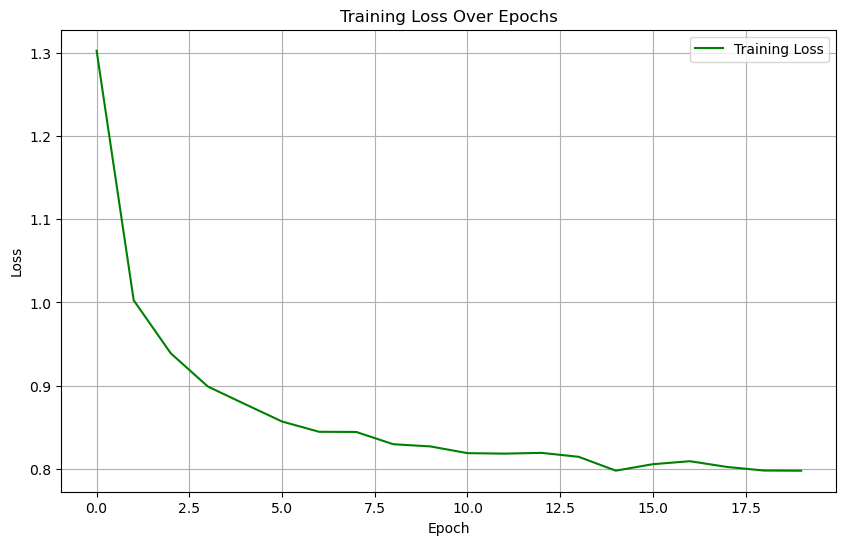

In [23]:
# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

##### 6.3 Model Evaluation with our data (node features)

In [24]:
model.eval()
with torch.no_grad():
    embeddings = model.encode(data_.x, data_.edge_index)

In [25]:
embeddings.shape

torch.Size([799, 64])

In [26]:
# Convert embeddings to NumPy for use with sklearn
embeddings_np = embeddings.cpu().numpy()

#### 7. Lets use Elbow method to find the optimal no of clusters

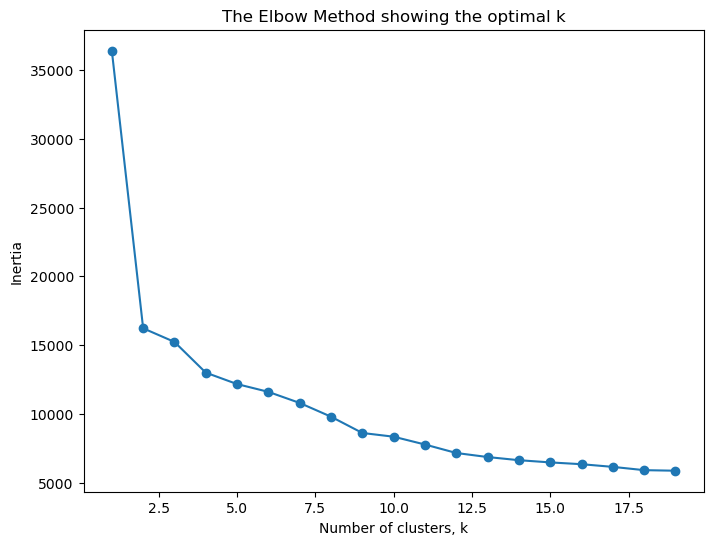

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(1, 20)  # Adjust the range based on your dataset

for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init='auto', random_state=42)
    kmeanModel.fit(embeddings_np)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [28]:
optimal_clusters = 8
optimal_clusters

8

#### 8. K-means clustering on the embeddings from GCN

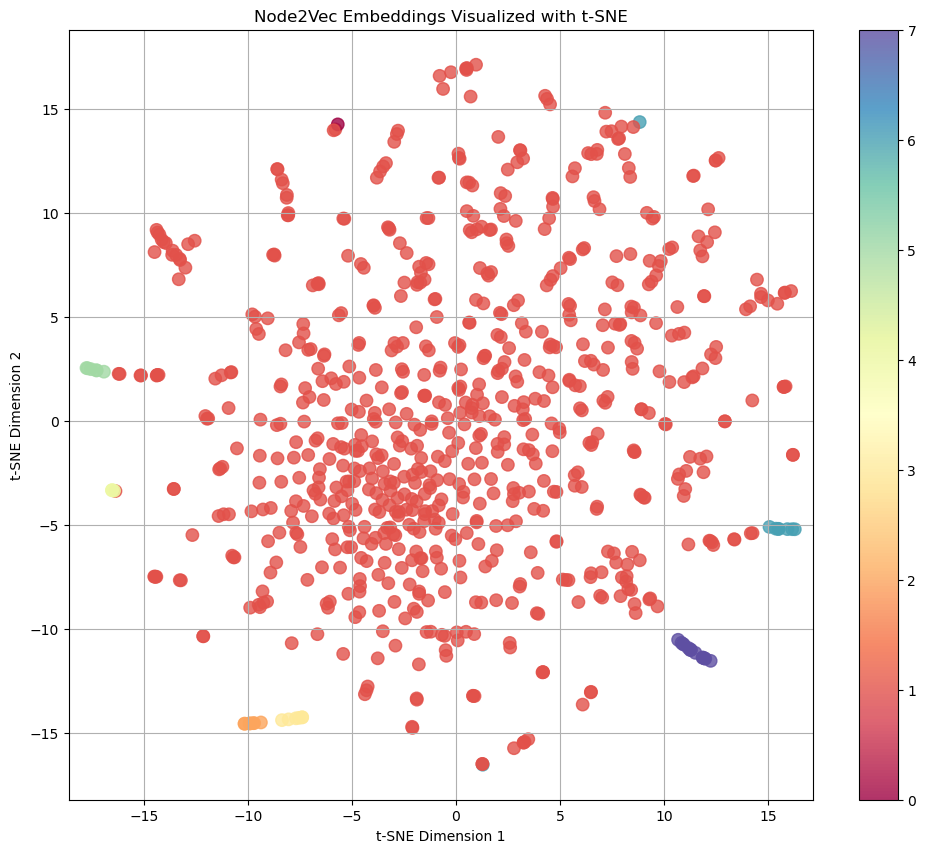

In [64]:
# Fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=optimal_clusters,n_init='auto').fit(embeddings_np)
labels = kmeans.labels_

# Using t-SNE for viusalizing the data points
tsne = TSNE(n_components=2, perplexity=55, n_iter=400)
tsne_results = tsne.fit_transform(embeddings_np)

# Visualization
plt.figure(figsize=(12, 10))  # Increase figure size for better visibility
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=80, c=kmeans.labels_, cmap='Spectral', alpha=0.8)

# Create a colorbar
plt.colorbar(scatter)

# Enhance the plot
plt.title("Node2Vec Embeddings Visualized with t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Optional: Add grid, set aspect
plt.grid(True)
plt.gca().set_aspect('equal', 'datalim')

plt.show()

#### 9. Results : Verifying and ploting the cluster

In [38]:
from collections import Counter

print("Total Number of clusters are:",len(Counter(kmeans.labels_)))

Total Number of clusters are: 8


In [39]:
from collections import Counter
for i in range(len(Counter(kmeans.labels_))):
  print("In cluster",i,"number of elemets are",Counter(kmeans.labels_)[i])

In cluster 0 number of elemets are 756
In cluster 1 number of elemets are 3
In cluster 2 number of elemets are 5
In cluster 3 number of elemets are 3
In cluster 4 number of elemets are 6
In cluster 5 number of elemets are 3
In cluster 6 number of elemets are 14
In cluster 7 number of elemets are 9


In [29]:
Cluster = []
for cluster in set(kmeans.labels_):
    i = np.array(G.nodes)[kmeans.labels_ == cluster]
    Cluster.append(sorted(i))

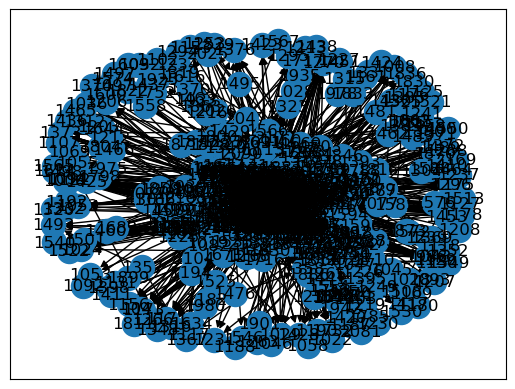

In [40]:
nx.draw_networkx(G.subgraph(Cluster[0]))

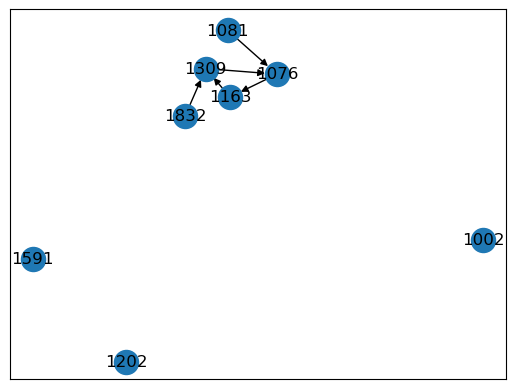

In [44]:
nx.draw_networkx(G.subgraph(Cluster[7]))